In [12]:
%reload_ext autoreload
#%load_ext autoreload
%autoreload 2

### Question 1:
Design & build a small dataset (about 100+ images) to differentiate between real and fake face images. Please explain:

    a. Considerations that went into deciding what data to collect.
    b. How you went about collecting the data.
    c. Besides fake/real labels, what other labels would you consider? Explain a simple method to sample a uniform dataset in the i.i.d sense, given the labels.
    d. What API (e.g Pandas, etc.) you used to store and organize meta information about the dataset.
    e. Please share your mini-dataset as a zip file.

### A. Considerations that went into deciding what data to collect.
    1. The dataset should ideally show a variety of deep fake operations, i.e. synthetic, identity swapping, attribute manipulation, and expression swap
    2. In addition, the dataset should have good demographic distribution of males, females, age distribution (young to old), different races and ethnicities.
    3. Restricted to image datasets as per the problem specification
    4. Was freely available with no behind firewall, paid licensing, or other such requirement.
    5. Was not too large to fit in my computer memory

## B. How data was collected

Identified two datasets that seem to have a variety of content satisfying the requirements above. 
Faces-HQ  is a dataset that was collected by Durall et al. as described in their 2019 paper "Unmasking DeepFakes with simple Features" (https://arxiv.org/abs/1911.00686)
Unmasking DeepFakes with simple Features
They created a database called Faces-HQ by collecting fake and real face data from multiple sources from CelebA-HQ dataset, Flickr-Faces-HQ dataset, 100K Facesproject and www.thispersondoesnotexist.com. In total, they had collected 40K high quality images being half of them real and the other half fake faces, achieving in this manner a balanced dataset.

Since this dataset had the real and fake images subdivided into categories describining the nature of the faking process, and seeming to cover the different methods of fake face generation. I chose this dataset for experimentation as I could sample from this distribution to approximate the IID requirement in part C of question 1. The dataset is available from :
https://drive.google.com/file/d/1rokPjCHe30mZBnk7J5j0MiIuUAuOqHoQ/view
For example, both real and fake belong to these major categories:
- exit_phone_room
- hugging_happy
- kitchen_pan
- kitchen_still
- meeting_serious
- outside_talking_pan_laughing
- outside_talking_still_laughing
- podium_speech_happy
- secret_conversation
- talking_against_wall
- talking_angry_couch
- walk_down_hall_angry
- walking_and_outside_surprised
- walking_down_indoor_hall_disgust
- walking_down_street_outside_angry
- walking_outside_cafe_disgusted


I also examined another dataset from Kaggle contributed by Aman Chaudhary that had an interesting racial mix of faces, possibly a late entry after the DFDC challenge was over. This dataset was used to train and test the CNN model described in answer to question 3. This dataset was downloaded from https://www.kaggle.com/datasets/agcy1210/fake-and-real-image-dataset?resource=download

## Besides fake/real labels, what other labels would you consider? Explain a simple method to sample a uniform dataset in the i.i.d sense, given the labels.

Since the goal is to classify fake and real, these are the top level labels of interest. However, in the Faces-HQ dataset, there was further labels at finer granularity. Looking at the distribution of these finer-grained labels, as shown by the cell below, we observe that the inner class labels are unbalanced in each real and fake classes.

- exit_phone_room 102
- hugging_happy 187
- kitchen_pan 17
- kitchen_still 323
- meeting_serious 51
- outside_talking_pan_laughing 170
- outside_talking_still_laughing 306
- podium_speech_happy 323
- secret_conversation 85
- talking_against_wall 255
- talking_angry_couch 238
- walk_down_hall_angry 85
- walking_and_outside_surprised 85
- walking_down_indoor_hall_disgust 204
- walking_down_street_outside_angry 102
- walking_outside_cafe_disgusted 85

Assuming the original data was an IID distribution, we sample the train,validate and test distributions randomly from each overall class so that the resulting incidence distributions of the inner classes remains similar to the original distributions. This type of sampling will insure the resulting splits are IID as well.

In [13]:
#this pre-processing was to make it easy to visualize the distribution of the datasets.
import os
import matplotlib.pyplot as plt

def collect_categstats(dirname,type,namelist=None): # helps generate incidence dist by accoutning for the number of images per category
    hist={}
    total=0
    
    for root, dirs, files in os.walk(dirname, topdown=False):
        for name in dirs:
            if (not name.startswith(".")):
                dir=os.path.join(root, name)
                #if "real" in dir:
                for root_dir, cur_dir, files in os.walk(dir):
                   # print(files)
                    count = len(files)
                    total+=count
                #print(count,type,name)
                hist[name]=count
    print("Total number of files in ", type," = ",total)
    od = {}
    
    for name in hist:
        if "__" in name:
            namecore=name.split("__")[1]
        else:
            namecore=name
        if namecore not in od:
            od[namecore]=hist[name]
        else:
            od[namecore]+=hist[name] # stores the namecores, mapped to the full file name
       
    if (namelist is None):
        namelist=[] # list of the namecores
        for namecore in od:
            namelist.append(namecore)
            print(namecore,od[namecore])
    return od,namelist # both are used for the histogram to get the data into the proper format
                    # helps with forming a flatter directory structure from 2 levels to 1 level for images

#plots the distribution of categories of the raw data
def plot_hist(hist1,hist2,namelist):
    names1=[]
    values1=[]
    names2=[]
    values2=[]
    for name in namelist:
        names1.append(name)
        if name in hist1:
            values1.append(hist1[name])
        else:
            values1.append(0)
        names2.append(name)
        if name in hist2:
            values2.append(hist2[name])
        else:
            values2.append(0)
  #  for i in range(len(names1)):
  #      print(names1[i],values1[i])
   #     print(names2[i],values2[i])
   # print(len(hist1) ," keys")
    plt.subplot(1, 2, 1) # row 1, col 2 index 1
    plt.bar(range(len(names1)), values1, tick_label=names1)
    plt.title("Real face distribution")
    plt.xlabel('The categories ')
    plt.ylabel('Number of Images Per Category')
    plt.subplot(1, 2, 2) # index 2
    plt.bar(range(len(names2)), values2, tick_label=names2)
    plt.title("Fake face distribution")
    plt.xlabel('The categories ')
    plt.ylabel('Number of Images Per Category')
    plt.show()

In [20]:
#This section loads the list of files into a pandas dataframe and uses random sampling to create the 100 image dataset

import pandas as pd
import shutil

#takes a listing of all files
def get_allfilelist(dirname):
    allfiles=[]
    for root, dirs, files in os.walk(dirname, topdown=False):
        for name in dirs:
            if (not name.startswith(".")):
                dir=os.path.join(root, name) 
            #if "real" in dir:
                for root_dir, cur_dir, files in os.walk(dir):
                    for file in files:
                        path=root_dir+"/"+file # name of the raw file name is preserved
                        allfiles.append(path) # append filename to list of all files
    return allfiles

#samples the data for the required number as per question1
def random_sampledata(dirname,num_samples,outdir): # returns df containing the sample subset data
    allfiles=get_allfilelist(dirname) # get all the files in the directory & sample 
    df = pd.DataFrame(allfiles)
    dfsample=df.sample(num_samples) # perform the default random sampling of the dataframe, helps maintain iid
    dfsample.columns=['Sample'] # names the dataframe column to distinguish the metadata 
    print(dfsample.head())
    return dfsample

#saving renders it into a flat structure with the subclass name built into the image name 
#  to simplify the model building for question 3
def save_sampleddata(df,outdir,key):
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    else:
        shutil.rmtree(outdir) # cleans the directory for a fresh sample set 
                            #recreate the directory path to overwrite the large number of files to the # of samples
        os.makedirs(outdir)
   # print(outdir)
    for ind in df.index:   
        name=str(df['Sample'][ind])
        innername=name.split(key)[1]
       # print("innername=",innername, name)
        innername=innername.replace("/","__") # changes the filename to reduce the number of subdirectory levels 
        outpath=outdir+"/"+innername
       # print("Copying ",name,outpath)
        shutil.copy(name, outpath) # copy the new file into the output directory
        
###Main function for Q1:
def prepare_sampledata(origdir,sampledir,num_samples,namelist): # combines all the major function calls
    realdir=origdir+"/real" # designates specific subdirectories
    fakedir=origdir+"/fake" # each directory is independently sampled, relates to IID distribution
    realsampledir=sampledir+"/real"
    fakesampledir=sampledir+"/fake"
    real_sample=random_sampledata(realdir,num_samples,realsampledir)
    fake_sample=random_sampledata(fakedir,num_samples,fakesampledir)
    save_sampleddata(real_sample,realsampledir,realdir+"/")
    save_sampleddata(fake_sample,fakesampledir,fakedir+"/")
    plot_samplehistDF(real_sample,fake_sample,namelist)
    
    
def plot_samplehistDF(df1,df2,namelist): # this function takes in dataframe input and a namelist of the folders
                                        # meant for debugging/testing purposes on sample file
    hMap1={} 
    hMap2={}
    dfindex=df1.index
   
    for ind in df1.index:
        name=str(df1['Sample'][ind])
       
        #name=str(dfcol[index])
       # print(name)
        if "__" in name:
            namecore=str(name).split("__")[1] #uses double __ to extract the namecore
        else:
            namecore=str(name)
       # print(namecore)
        
        namecore=namecore.split("/")[0]
      #  print(namecore)
        if namecore not in hMap1:
            hMap1[namecore]=1
        else:
            hMap1[namecore]+=1
    for ind in df2.index:
        name=str(df2['Sample'][ind])
        if "__" in name:
            namecore=str(name).split("__")[1]
        else:
            namecore=str(name)
        namecore=namecore.split("/")[0]
       # print(namecore)
        if namecore not in hMap2:
            hMap2[namecore]=1
        else:
            hMap2[namecore]+=1
   # print(len(hMap1),len(hMap2))
    plot_hist(hMap1,hMap2,namelist)
    
def get_original_distrib(origdir):
    od_real,namelist=collect_categstats(origdir+"/real","real")
    od_fake,namelist=collect_categstats(origdir+"/fake","fake",namelist)

    plot_hist(od_real,od_fake,namelist)
    return namelist

In [21]:
origdir="../data/original" # this directory has been removed from the github submission due to size constraints
                           # the original data taken from the Face-HQ dataset  https://drive.google.com/file/d/1rokPjCHe30mZBnk7J5j0MiIuUAuOqHoQ/view . 
                           # Please download and put this in a suitable location and change the origdir pointer here.
                           # The format of the directory is specified in README
sampledir="../data/sampled"
num_samples=50 #per class     # this number can change according to how many samples you want per category 


Total number of files in  real  =  2468
outside_talking_still_laughing 335
hugging_happy 180
walking_down_street_outside_angry 44
podium_speech_happy 342
talking_against_wall 261
kitchen_still 324
walking_down_indoor_hall_disgust 186
walking_and_outside_surprised 85
talking_angry_couch 255
outside_talking_pan_laughing 43
secret_conversation 51
walking_outside_cafe_disgusted 78
exit_phone_room 38
walk_down_hall_angry 32
meeting_serious 60
kitchen_pan 3
Total number of files in  fake  =  1680


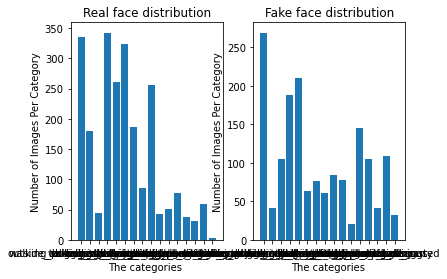

                                                 Sample
1695  ../data/original/real/23__walking_down_indoor_...
1860  ../data/original/real/15__outside_talking_stil...
477   ../data/original/real/06__talking_against_wall...
242   ../data/original/real/01__walking_down_indoor_...
547    ../data/original/real/19__kitchen_still/4409.jpg
                                                 Sample
874   ../data/original/fake/26_03__walk_down_hall_an...
871   ../data/original/fake/26_03__walk_down_hall_an...
428   ../data/original/fake/09_18__walking_down_stre...
1587  ../data/original/fake/11_13__outside_talking_s...
718   ../data/original/fake/14_21__walking_down_stre...
walking_down_indoor_hall_disgust/710.jpg
outside_talking_still_laughing/1062.jpg
talking_against_wall/335.jpg
walking_down_indoor_hall_disgust/2972.jpg
kitchen_still/4409.jpg
podium_speech_happy/4788.jpg
outside_talking_still_laughing/2379.jpg
talking_against_wall/3270.jpg
secret_conversation/4211.jpg
podium_speech_happy/534.j

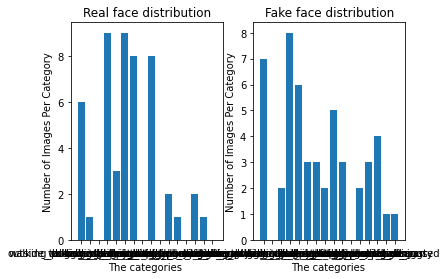

In [22]:
namelist=get_original_distrib(origdir)
prepare_sampledata(origdir,sampledir,num_samples,namelist)